# 22 textes pour marionnettes de Duranty #

## Etape 3 : Topic Modeling ##

Jusqu'à maintenant, nous avons fait de la classification non supervisée, où l'ordinateur distribuait librement chaque document en fonction de la répartition de ses mots.

Nous allons ici développer un peu cela en faisant du topic modeling : cette fois-ci, chaque mot est assimilé à un sujet (ou plus précisément à une variété de sujets dont la proximité est donnée sous la forme d'une coefficient relatif à chacun des sujets), et l'addition de chacun de ces coefficients pour chaque mot détermine pour chaque abstract un sujet (ou plutôt une liste de thèmes dont la proximité est indiquée sous la forme d'un coefficient). Grâce à cela, on peut déterminer des clusters fondés non plus la répétitivité de certains termes ou de certaines constructions, mais sur les champs lexicaux utilisés.

Nous nous appuierons pour cela sur divers librairies qu'il convient d'importer.

## Les packages ##

In [3]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# SpaCy pour la lemmatisation
import spacy

# Librairies pour la représentation en schéma
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# Active le chargement pour Gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#Permet d'utiliser LDA Mallet dans la seconde partie de l'analyse
import git
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet

#Permet de taper des lignes de commande du terminal directement dans Python
import subprocess

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Les stopwords ##

Je définis des stopwords, c'est à dire la liste de mots qui ne doivent pas être pris en compte, ces mots étant généralement des mots grammaticaux. Les mots grammaticaux sont généralement très nombreux mais portent un très faible poids sémantique. Il faut donc les retirer pour éviter qu'ils n'occultent les autres mots à cause de leur surreprésentation.

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('french')
stop_words.extend(['el']) #permet d'ajouter certains termes que j'ai décrété

## Choisir son corpus ##

Il faut activer l'une des deux cellules (au choix) pour charger en mémoire le corpus traité de la manière que vous voulez.

Le meilleur choix pour un premier test est de choisir le texte lemmatisé.

In [5]:
#Pour utiliser les textes stemmés, c'est ici
import os
documents = []
Path = "./cache1864/cacheSTEM/"
filelist = os.listdir(Path) #filelist est une liste regroupant tous les chemins vers les différents textes.

for abstract in filelist:
    with open(Path + abstract, "r", encoding="UTF-8") as y:
        texte = y.read()
        documents.append(texte)

In [6]:
#Pour utiliser les textes lemmatisés, c'est ici
import os
documents = []
Path = "./cache1864/cacheLEM/"
filelist = os.listdir(Path) #filelist est une liste regroupant tous les chemins vers les différents textes.

for abstract in filelist:
    with open(Path + abstract, "r", encoding="UTF-8") as y:
        texte = y.read()
        documents.append(texte)

## Topic modeling partie 1 : définir des topic ##

### Séquençage et nettoyage ###

Tout d'abord, je définis une fonction qui séquence chaque abstract en mot et retire la ponctuation. C'est l'étape du préprocessing, c'est à dire formatter le document afin de le rendre lisible par gensim. Gensim a sa propre méthode de séquençage, que nous utiliserons. Nous avons déjà lemmatisé les documents, mais il est utile de le refaire, car cette fois-ci nous utiliserons le lemmatiseur intégré à Gensim, qui permet alors de rendre un document utilisable par Gensim.

Chaque document, sous la forme d'une str, devient une liste de str.

In [7]:
def sent_to_words(documents):
    for document in documents:
        yield(gensim.utils.simple_preprocess(str(document), deacc=True))  # deacc=True retire la ponctuation

data_words = list(sent_to_words(documents)) #je lemmatise les textes et les stock dans une variable

print(data_words[:1]) #Voici à quoi ressemble un extrait du corpus lemmatisé

[['le', 'mariage', 'de', 'raison', 'un', 'chambre', 'pierrot', 'et', 'degre', 'degre', 'trifouillon', 'me', 'trifouillon', 'bulayant', 'voila', 'moi', 'je', 'aime', 'pordre', 'et', 'le', 'propreter', 'un', 'petit', 'menage', 'bien', 'faire', 'que', 'de', 'poussiere', 'mon', 'dieu', 'lui', 'tousse', 'et', 'eternue', 'je', 'etre', 'garcon', 'de', 'moins', 'je', 'ne', 'etre', 'point', 'marier', 'et', 'ne', 'vouloir', 'pas', 'me', 'marier', 'mon', 'voisin', 'pierrot', 'avoir', 'jurer', 'qu', 'il', 'obligerait', 'epouser', 'ah', 'ah', 'ah', 'il', 'etre', 'tres', 'drole', 'ce', 'petit', 'pierrot', 'lui', 'faire', 'son', 'lit', 'la', 'tout', 'etre', 'ranger', 'est', 'ce', 'gentil', 'ici', 'lui', 'serre', 'un', 'serviette', 'dans', 'le', 'commode', 'avoir', 'present', 'je', 'aller', 'me', 'faire', 'mon', 'petit', 'bouillon', 'un', 'velours', 'pour', 'le', 'estomac', 'eh', 'et', 'cacher', 'mon', 'tirelire', 'lui', 'se', 'assied', 'el', 'ecume', 'son', 'marmite', 'oh', 'que', 'cela', 'sentir', '

### Construire les bigrammes et les trigrammes ###

Nous allons maintenant construire les bigrammes et les trigrammes, c'est à dire rassembler les mots par groupe de 2 ou 3 en fonction de leur ressemblance sémantique, permettant de dégager ainsi des débuts de regroupement.

Nous créons donc les modèles pour créer les bigrammes et les trigrammes, qui donnent une liste de mots assignés à chaque mot un à un. Nous testons à la fin un exemple de la liste de mot.

In [8]:
# Construit les modèles bigramme et trigramme
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # plus le paramètre threshold est haut, plus il est difficile de construire des groupes de mots
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# On applique la méthode et les modèles dans une variable
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Un exemple d'une trigrammes avec le premier mot.
print(trigram_mod[bigram_mod[data_words[0]]])

['le', 'mariage', 'de', 'raison', 'un', 'chambre', 'pierrot', 'et', 'degre', 'degre', 'trifouillon', 'me', 'trifouillon', 'bulayant', 'voila', 'moi', 'je', 'aime', 'pordre', 'et', 'le', 'propreter', 'un', 'petit', 'menage', 'bien', 'faire', 'que', 'de', 'poussiere', 'mon', 'dieu', 'lui', 'tousse', 'et', 'eternue', 'je', 'etre', 'garcon', 'de', 'moins', 'je', 'ne', 'etre', 'point', 'marier', 'et', 'ne', 'vouloir', 'pas', 'me', 'marier', 'mon', 'voisin', 'pierrot', 'avoir', 'jurer', 'qu', 'il', 'obligerait', 'epouser', 'ah', 'ah', 'ah', 'il', 'etre', 'tres', 'drole', 'ce', 'petit', 'pierrot', 'lui', 'faire', 'son', 'lit', 'la', 'tout', 'etre', 'ranger', 'est', 'ce', 'gentil', 'ici', 'lui', 'serre', 'un', 'serviette', 'dans', 'le', 'commode', 'avoir', 'present', 'je', 'aller', 'me', 'faire', 'mon', 'petit', 'bouillon', 'un', 'velours', 'pour', 'le', 'estomac', 'eh', 'et', 'cacher', 'mon', 'tirelire', 'lui', 'se', 'assied', 'el', 'ecume', 'son', 'marmite', 'oh', 'que', 'cela', 'sentir', 'b

Nous insérons ensuite les modèles dans des fonctions :

In [9]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Puis ensuite nous l'appliquons à notre set de textes.

In [10]:
# On retire les stop words
data_words_nostops = remove_stopwords(data_words)

# On forme les bigrammes
data_words_bigrams = make_bigrams(data_words_nostops)

# On lemmatise le texte grâce à spacy. J'utilise le corpus d'entraînement le plus petit à notre disposition.
nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])

# Je ne lemmatise qu'en ne gardant les noms, les adjectifs, les verbes et les adverbes
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Exemple du résultat sur le premier abstract
print(data_lemmatized[:1])

[['mariage', 'raison', 'chambr', 'degr', 'degr', 'trifouillon', 'trifouillon', 'bulayant', 'voiler', 'pordre', 'propreter', 'petit', 'menage', 'bien', 'faire', 'tousse', 'eternue', 'garcon', 'moins', 'point', 'marier', 'pierrot', 'epouser', 'tre', 'drole', 'petit', 'faire', 'lit', 'tout', 'ranger', 'gentil', 'ici', 'serviette', 'commode', 'present', 'aller', 'faire', 'petit', 'bouillon', 'velours', 'estomac', 'cacher', 'tirelir', 'assied', 'ecume', 'marmite', 'sentir', 'bon', 'savoir', 'comment', 'prendre', 'forcer', 'epouser', 'enfin', 'forcer', 'faire', 'sauter', 'mariage', 'raison', 'pierrot', 'avoir', 'promettre', 'epou', 'ser', 'boire', 'trifouillon', 'vraiment', 'Monsieur', 'aller', 'faire', 'maitre', 'pjierrot', 'gouter', 'trempe', 'marmil', 'nez', 'bouillon', 'maitr', 'ainsi', 'pretendr', 'plair', 'savoir', 'commissaire', 'demeur', 'loin', 'ici', 'pierrot', 'parlon', 'serieusemer', 'ainsi', 'Monsieur', 'trifouillon', 'bon', 'excellent', 'Monsieur', 'trifouillon', 'cher', 'amie'

Ensuite, les mots de chaque texte sont encodés sous la forme de tuple où le premier entier est son identifiant et où le second est son nombre d'occurences.

In [11]:
# Je crée le dictionnaire dans lequel est stocké chaque mot différent en clé et un identifiant (nombre entier) en valeur
id2word = corpora.Dictionary(data_lemmatized)

# J'associe le corpus à une variable lemmatisé
texts = data_lemmatized

# Je crée une liste avec à l'intérieur une liste de deux entiers où le premier représente un mot (la valeur de la clé du dictionnaire id2word) et le second est son nombre d'occurence
corpus = [id2word.doc2bow(text) for text in texts]

# Visualisation un peu barbare sur le premier corpus
print(corpus[:1])

[[(0, 17), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 6), (8, 1), (9, 1), (10, 2), (11, 1), (12, 21), (13, 5), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 3), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 10), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 2), (41, 3), (42, 2), (43, 1), (44, 1), (45, 1), (46, 3), (47, 1), (48, 16), (49, 1), (50, 6), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 25), (64, 3), (65, 1), (66, 1), (67, 2), (68, 11), (69, 1), (70, 4), (71, 1), (72, 2), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 7), (102, 2), (103, 1), (104, 1), (105, 4), (106, 1), (107, 4), (108, 1), (109, 1), (1

Pour mieux le comprendre, voici une visualisation adaptée à un être humain :

In [12]:
# Voici une version un peu plus lisible. C'est purement de la term-frequency, à l'état brut.
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('Monsieur', 17),
  ('ab', 1),
  ('abandonn', 1),
  ('abattre', 1),
  ('abimer', 1),
  ('affaire', 1),
  ('affreux', 2),
  ('ah', 6),
  ('aim', 1),
  ('aimerai', 1),
  ('ainsi', 2),
  ('al', 1),
  ('aller', 21),
  ('allon', 5),
  ('ameonrer', 1),
  ('ami', 1),
  ('amie', 1),
  ('amitie', 1),
  ('apparaitre', 1),
  ('appartienn', 1),
  ('appeler', 3),
  ('applau', 1),
  ('apprendre', 1),
  ('appri', 1),
  ('aqoiener', 1),
  ('arbre', 1),
  ('argent', 1),
  ('armnire', 1),
  ('armoir', 10),
  ('arracher', 1),
  ('arranger', 1),
  ('asse', 1),
  ('asseoir', 1),
  ('assez', 1),
  ('assied', 1),
  ('assiette', 1),
  ('assoier', 1),
  ('assurer', 2),
  ('at', 1),
  ('atieindre', 1),
  ('attend', 2),
  ('attendre', 3),
  ('aussi', 2),
  ('aussitol', 1),
  ('aussitot', 1),
  ('autour', 1),
  ('autre', 3),
  ('aveugler', 1),
  ('avoir', 16),
  ('bah', 1),
  ('balai', 6),
  ('barie', 1),
  ('bas', 1),
  ('battent', 1),
  ('battr', 2),
  ('bdlon', 1),
  ('beaucoup', 1),
  ('bee', 1),
  ('bei', 

### Construire l'attribution des sujets ###

La LDA (latent Dirichlet Allocation) est une méthode permettant de définir que si certains thèmes sont observés dans un corpus, nous pouvons alors dire que chacun des mots du corpus peuvent être attribués à l'un de ces thèmes.

Nous allons appliquer l'algorithme LDA de Gensim à notre corpus en souhaitant 8 topics dans lequel les corpus seront rangés.

In [13]:
# Je construis mon algorithme de LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1, #update_every détermine avec quelle régularité il faut remettre le modèle à jour
                                           chunksize=100, #chunksize définit le nombre de documents à utiliser dans chaque passage
                                           passes=10, #passes est le nombre total de passage
                                           alpha='auto',
                                           per_word_topics=True)

Nous pouvons alors trouver les mots clés les plus pertinents de chaque cluster que la machine a trouvé :

In [14]:
# J'affiche les mot-clés des 8 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.058*"cassandre" + 0.023*"faire" + 0.017*"bien" + 0.016*"bon" + '
  '0.015*"aller" + 0.012*"domestique" + 0.010*"prendre" + 0.009*"jeannette" + '
  '0.006*"avoir" + 0.006*"colique"'),
 (1,
  '0.017*"bien" + 0.016*"cassandre" + 0.015*"faire" + 0.014*"aller" + '
  '0.014*"polichinelle" + 0.014*"pierrot" + 0.012*"Monsieur" + 0.011*"avoir" + '
  '0.011*"gribiche" + 0.011*"non"'),
 (2,
  '0.022*"pierrot" + 0.018*"aller" + 0.018*"polichinelle" + 0.014*"corbeau" + '
  '0.014*"ramoneur" + 0.014*"faire" + 0.014*"bien" + 0.013*"arlequin" + '
  '0.013*"patissier" + 0.011*"avoir"'),
 (3,
  '0.001*"polichinelle" + 0.001*"faire" + 0.001*"bien" + 0.000*"avoir" + '
  '0.000*"pierrot" + 0.000*"aller" + 0.000*"cassandre" + 0.000*"plus" + '
  '0.000*"polichinell" + 0.000*"donc"'),
 (4,
  '0.025*"polichinelle" + 0.019*"pierrot" + 0.018*"bien" + 0.016*"niflanguill" '
  '+ 0.015*"aller" + 0.015*"faire" + 0.012*"polichinell" + 0.011*"avoir" + '
  '0.010*"domestique" + 0.010*"sorcier"'),
 (5,
  '0.00

### Critique du calcul : le score de cohérence ###

La perplexité et le score de cohérence permettent de définir si les groupes générés par topic sont cohérents, c'est à dire s'il y a trop ou pas assez de groupes, et si les groupes sont vraiment représentés par ce topic, si ce topic est vraiment au coeur des textes.

In [15]:
# Je calcule la Perplexité
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # permet de savoir si le modèle est bon. Plus c'est bas, mieux c'est.

# Je calcule le score de cohérence.
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.419110538857608

Coherence Score:  0.25618007198025355


### Visualisation ###

Grâce à cette carte interactive, nous pouvons visualiser la répartition des thèmes et des mots-clés dans chaque cluster.

In [16]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.103000  0.027189       1        1  28.796459
2      0.128608  0.001661       2        1  16.663942
12     0.100524  0.111917       3        1  11.812680
4      0.128960 -0.054577       4        1  11.741287
11     0.122311 -0.018164       5        1  10.580431
14     0.054638  0.108950       6        1   4.746538
8      0.050959 -0.069251       7        1   4.655592
0      0.034687  0.044367       8        1   4.532267
9      0.007852 -0.111319       9        1   3.583737
13     0.016384 -0.085592      10        1   2.879811
7     -0.144264  0.009393      11        1   0.001492
6     -0.148392  0.008886      12        1   0.001462
5     -0.158800  0.007980      13        1   0.001435
10    -0.147177  0.009962      14        1   0.001434
3     -0.149289  0.008599      15        1   0.001433, topic_info=              Term        Freq       Total Category  logprob  loglift
1769  polichinelle  541.000000  541.000000  Default  30.0000  30.0000
1550     cassandre  425.000000  425.000000  Default  29.0000  29.0000
1132      arlequin  194.000000  194.000000  Default  28.0000  28.0000
413        pierrot  503.000000  503.000000  Default  27.0000  27.0000
1768   polichinell  234.000000  234.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
800          homme    0.000127   89.764214  Topic15  -8.1509  -2.3127
118    commissaire    0.000128   99.471313  Topic15  -8.1459  -2.4104
502           tair    0.000129  113.593712  Topic15  -8.1382  -2.5354
7               ah    0.000131  145.014893  Topic15  -8.1262  -2.7676
136           coup    0.000128  162.519012  Topic15  -8.1458  -2.9012

[1043 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.443424  Monsieur
0         2  0.107748  Monsieur
0         3  0.132613  Monsieur
0         4  0.074595  Monsieur
0         5  0.095315  Monsieur
...     ...       ...       ...
1506      6  0.746072     vousa
4601     10  0.799885      xiii
4602     10  0.800225        xv
4603     10  0.799774      xvii
5710      8  0.692311  zannette

[1499 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 13, 5, 12, 15, 9, 1, 10, 14, 8, 7, 6, 11, 4])

## LDA Mallet Model ##

### Passage de l'algorithme de Gensim à celui de Mallet ###

Pour la suite, nous utiliserons l'algorithme de topic modeling de Mallet plutôt que celui proposé par Gensim. Bien que Gensim offre une meilleure approche de Topic Modeling, car chaque étape est bien séparée et peut être personnalisée (nettoyage de la donnée ou *preprocessing*, construction et paramètrage du modèle de Topic Modeling), l'algorithme de Topic Modeling proposé par Mallet est un peu plus précis que celui de Gensim, en offrant notamment une meilleure qualité de sujets.

En 2014 Radim Řehůřek, créateur de Gensim, a créé un Wrapper permettant d'utiliser l'algorithme de Mallet. Nous allons donc télécharger les dossiers de Mallet depuis GitHub et utiliser ce wrapper pour utiliser l'algorithme de Mallet.

Les Topics mesurés seront légèrement différents. Tout d'abord, il faut télécharger Mallet dans le cache :

In [17]:
if not os.path.exists('./cache1864/Mallet'):
    git.Git("./cache1864").clone("https://github.com/mimno/Mallet.git")

Nous avons téléchargé l'algorithme de Mallet. Celui-ci fonctionnant en Java, il faut d'abord compiler le programme avant de l'utiliser.

Il suffit de lancer la case suivante pour compiler l'algorithme grâce au compilateur Ant Apache, qui a été installé en suivant les demandes du README. La compilation est réalisée si la case ci-dessous indique "build successful".

In [18]:
compilation =  subprocess.Popen("'ant' '-f' './cache1864/Mallet/build.xml'", shell=True, stdout=subprocess.PIPE).stdout
resultat =  compilation.read()

print(resultat.decode())

Buildfile: /home/probert5/Documents/duranty_text_analyze/traitement/1864/cache1864/Mallet/build.xml

init:
     [copy] Copying 1 file to /home/probert5/Documents/duranty_text_analyze/traitement/1864/cache1864/Mallet/class

compile:

BUILD SUCCESSFUL
Total time: 0 seconds



In [19]:
mallet_path = "./cache1864/Mallet/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

**Important**
Si une erreur se déclenche, c'est que la compilation n'a pas fonctionné. Allez manuellement dans cache2019/Mallet, ouvrez votre terminal et tapez simplement " ant ". Relancez ensuite la cellule, cela fonctionnera normalement à chaque lancement.

In [20]:
# Voici les "nouveaux" topics calculés par Mallet
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('gripandouill', 0.04362850971922246),
   ('corbeau', 0.03455723542116631),
   ('ramoneur', 0.03412526997840173),
   ('voix', 0.03023758099352052),
   ('haut', 0.027645788336933045),
   ('aller', 0.025053995680345574),
   ('faire', 0.01900647948164147),
   ('avoir', 0.017710583153347732),
   ('bas', 0.017710583153347732),
   ('roi_noir', 0.015982721382289417)]),
 (1,
  [('polichinelle', 0.16825483256193846),
   ('polichinell', 0.07269262183501225),
   ('sorcier', 0.032943098284780835),
   ('bien', 0.025864416008712223),
   ('aller', 0.025047644976858154),
   ('avoir', 0.02368635992376804),
   ('diable', 0.018241219711407568),
   ('bon', 0.011434794445956983),
   ('donc', 0.01116253743533896),
   ('petit', 0.01116253743533896)]),
 (2,
  [('arlequin', 0.07860732232591529),
   ('commissaire', 0.03948312993539124),
   ('pierrot', 0.02763819095477387),
   ('capitaine', 0.026920315865039485),
   ('Monsieur', 0.02512562814070352),
   ('faire', 0.021536252692031587),
   ('bien', 0.0197

Nous pouvons comparer le score de cohérence de ces algorithmes :

In [21]:
# Je calcule le score de cohérence de Mallet
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score of LDA Mallet : ', coherence_ldamallet)

# Je calcule le score de Gensim
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score of LDA Gensim : ', coherence_lda)


Coherence Score of LDA Mallet :  0.2537509642325836

Coherence Score of LDA Gensim :  0.25618007198025355


Comme on peut le voir, Mallet est légèrement meilleur que Gensim. Il y a donc un certain intérêt à continuer avec Mallet.

### Critique du choix du nombre de clusters ###

Nous allons ici voir si le nombre de clusters choisi est vraiment représentatif et optimal. Pour calculer cela, nous nous baserons sur la " cohérence ", un coefficient calculé par l'ordinateur. Tout d'abord, nous créons une fonction permettant de calculer la cohérence :

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Calcule la cohérence c_v pour un nombre variable de topics

    Parameters:
    ----------
    dictionary : Dictionnaire de Gensim
    corpus : Corpus de Gensim
    texts : Liste des corpus
    limit : Nombre maximum de corpus

    Returns:
    -------
    model_list : Liste des modèles de topic LDA topic
    coherence_values : Valeur de la cohérence correspondance au model de LDA et son nombre de topics respectif
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Puis nous cherchons à voir si cela est vraiment cohérent. Nous appliquons cette fonction au corpus. La fonction lancée ci-dessous va attribuer à chaque "model_list", une élément propre à Gensim regroupant la liste des topics attribués à un corpus (élément copié sur celui de Mallet mais avec cet avantage de ne pas stocker dans la RAM les textes, allégeant grandement le processus) la variable "coherence_values" qui est une liste constituée de nombres décimaux représentant la cohérence de chaque topic.

In [23]:
# Peut prendre du temps
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

Puis nous affichons le résultat sous la forme d'un graphique :

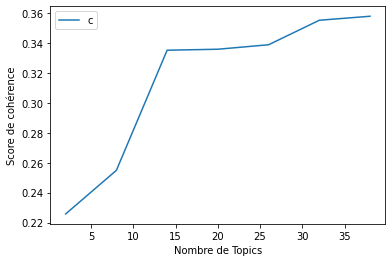

In [24]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Nombre de Topics")
plt.ylabel("Score de cohérence")
plt.legend(("coherence_values"), loc='best')
plt.show()

Nous voyons qu'il y a un pic à 8 topics, un autre à 20, puis à partir de 32 topics le score de cohérence monte en flèche. Le pic à 8 topics est intéressant, car c'est le nombre de " topics " différents proposés lors de la Conférence TEI 2019. L'augmentation finale permet cependant de comprendre que les abstracts restent relativement peu liés les uns aux autres, et que le nombre optimal de topics pour l'ordinateur serait d'un topic par abstract...

Nous affichons ici ensuite le score de cohérence précis pour une suite de nombre de topics, pour avoir une vision plus précise : par exemple, il est légèrement mieux d'avoir 8 topics que 20 topics, ce qui conforte l'idée que les abstracts sont guidés par 8 sujets différents, ceux attribués par les organisateurs de la conférence TEI.

In [25]:
for m, cv in zip(x, coherence_values):
    print("Nombre de Topics =", m, " a une valeur de cohérence de : ", round(cv, 4))

Nombre de Topics = 2  a une valeur de cohérence de :  0.2258
Nombre de Topics = 8  a une valeur de cohérence de :  0.2549
Nombre de Topics = 14  a une valeur de cohérence de :  0.3352
Nombre de Topics = 20  a une valeur de cohérence de :  0.3359
Nombre de Topics = 26  a une valeur de cohérence de :  0.3389
Nombre de Topics = 32  a une valeur de cohérence de :  0.3553
Nombre de Topics = 38  a une valeur de cohérence de :  0.358


### Voir les topics ###

La cellule ci-dessous permet d'afficher pour chaque topic (représenté par un nombre entier) les 10 mots-clés représentant le mieux ce topic, et un facteur attribué à chacun de ces mots permettant de voir l'importance de chaque mot-clé au sein du cluster.

In [26]:
optimal_model = model_list[1] #optimal_model et model_list sont des éléments gensim contenant les topics et les textes. 
#Model_list est la liste des modèles de nombres de topics et la distribution interne donnée ci-dessus. Comme le modèle le plus efficace est
#celui à 8 topics, je le sélectionne
model_topics = optimal_model.show_topics(formatted=False) #Model_topics est une liste produite par la méthode show_topics.
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.106*"pierrot" + 0.023*"patissier" + 0.019*"gendarm" + 0.017*"aller" + '
  '0.016*"faire" + 0.015*"avoir" + 0.014*"gendarme" + 0.014*"prendre" + '
  '0.012*"apothicair" + 0.012*"ah"'),
 (1,
  '0.034*"faire" + 0.029*"niflanguill" + 0.026*"aller" + 0.022*"bon" + '
  '0.019*"prendre" + 0.018*"domestique" + 0.017*"bien" + 0.013*"mettre" + '
  '0.013*"drole" + 0.011*"dire"'),
 (2,
  '0.149*"cassandre" + 0.033*"colombine" + 0.031*"faire" + 0.025*"corbeau" + '
  '0.025*"ramoneur" + 0.022*"voix" + 0.021*"cababuch" + 0.020*"haut" + '
  '0.015*"bien" + 0.012*"cababuche"'),
 (3,
  '0.158*"polichinelle" + 0.068*"polichinell" + 0.031*"aller" + '
  '0.031*"sorcier" + 0.020*"diable" + 0.015*"bon" + 0.014*"bien" + '
  '0.011*"donc" + 0.011*"donner" + 0.010*"avoir"'),
 (4,
  '0.042*"roi" + 0.030*"pierrot" + 0.027*"grand" + 0.023*"faire" + '
  '0.019*"avoir" + 0.017*"medecin" + 0.016*"astrologue" + 0.015*"bien" + '
  '0.012*"autre" + 0.011*"fort"'),
 (5,
  '0.044*"Monsieur" + 0.039*"bien" + 0.0

### Visualisation ###

Nous allons produire sous la forme d'un tableau le sujet dominant de chaque texte.

In [27]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=documents):
    # Iniatilise la sortie en un tableau pandas
    sent_topics_df = pd.DataFrame()

    # Récupère le sujet principal de chaque document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        #Récupère pour chaque document le sujet dominant, le pourcentage de contribution à ce sujet et les mots-clés
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Ajout du titre dans la dernière colonne en prenant les premiers mots de chaque texte
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=documents)

# Mise en place du tableau
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document n°', 'Topic dominant n°', 'Pourcentage de Contribution au topic', 'Mots-clés', 'Texte']

# Affiche le tableau en présentant seulement les 10 premiers textes. Changez le chiffre 10 si vous le souhaitez pour obtenir l'étude de plus de textes.
df_dominant_topic.head(46)

,Document n°,Topic dominant n°,Pourcentage de Contribution au topic,Mots-clés,Texte
0,0,7.0,0.3815,"arlequin, pierrot, capitaine, coup, trifouillo...",le mariage de raison \n\n un chambre . \n\n pi...
1,1,4.0,0.6387,"roi, pierrot, grand, faire, avoir, medecin, as...",le comete \n\n roi mirambol \n\n premier parti...
2,2,5.0,0.6212,"Monsieur, bien, faire, oui, gribiche, homme, a...",le malle de berlingue \n\n \n\n premier PARTIE...
3,3,3.0,0.3462,"polichinelle, polichinell, aller, sorcier, dia...",le homme AU cabriolet \n\n premier partie \n\n...
4,4,1.0,0.3939,"faire, niflanguill, aller, bon, prendre, domes...","le revenant \n\n un jardin avec un maison , \n..."
5,5,0.0,0.2752,"pierrot, patissier, gendarm, aller, faire, avo...",polichinelle \n\n PRÉCEPTEUR \n\n place public...
6,6,6.0,0.6217,"aller, gripandouill, main, vieux, coup, sac, c...",le boudin \n\n de \n\n GRIPANDOUILLE \n\n \n\n...
7,7,2.0,0.3826,"cassandre, colombine, faire, corbeau, ramoneur...",le miroir \n\n de colombine \n\n colombine . —...
8,8,2.0,0.3583,"cassandre, colombine, faire, corbeau, ramoneur...",le voisin \n\n premier parti . \n\n Polichinel...
9,9,7.0,0.4371,"arlequin, pierrot, capitaine, coup, trifouillo...",le marchand \n\n de coup de baton \n\n \n\n pl...


Nous pouvons remarquer que le modèle représenté fonctionnerait autour d'un texte central souvent très représentatif pour chaque cluster.
Cependant, chaque abstract est lié par une petite base solide à son topic (minimum 15%), ce qui indique que les textes ne sont pas totalement séparés les uns et des autres, et donc qu'une certaine thématique générale (bien évidemment la TEI) les relie.

La cohérence thématique entre tous ces abstracts n'est donc pas très profonde, et bien souvent il semblerait que la thématique d'un groupe d'abstract ne représenterait réellement qu'un seul abstract.

### Chercher les textes les plus représentatifs ###

Nous pouvons alors chercher à sortir les abstracts les plus représentatifs de chaque topic :

In [28]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic n°', "Pourcentage de contribution à un topic", "Mots-Clés", "Texte"]

# Show
sent_topics_sorteddf_mallet.head(8)

,Topic n°,Pourcentage de contribution à un topic,Mots-Clés,Texte
0,0.0,0.5988,"pierrot, patissier, gendarm, aller, faire, avo...",le plaideur \n\n malgré lui . \n\n premier par...
1,1.0,0.5714,"faire, niflanguill, aller, bon, prendre, domes...",le drogue \n\n de \n\n cataclysterium \n\n un ...
2,2.0,0.6793,"cassandre, colombine, faire, corbeau, ramoneur...",le fortune \n\n DU RAMONEUR \n\n \n\n premier ...
3,3.0,0.4955,"polichinelle, polichinell, aller, sorcier, dia...",le tonneau \n\n ( le thédtre représente un pla...
4,4.0,0.6387,"roi, pierrot, grand, faire, avoir, medecin, as...",le comete \n\n roi mirambol \n\n premier parti...
5,5.0,0.6212,"Monsieur, bien, faire, oui, gribiche, homme, a...",le malle de berlingue \n\n \n\n premier PARTIE...
6,6.0,0.6217,"aller, gripandouill, main, vieux, coup, sac, c...",le boudin \n\n de \n\n GRIPANDOUILLE \n\n \n\n...
7,7.0,0.4371,"arlequin, pierrot, capitaine, coup, trifouillo...",le marchand \n\n de coup de baton \n\n \n\n pl...


La théorie formulée précédemment semble se vérifier : certains abstracts incarnent à eux seuls leur topic.

Cependant, les résultats que nous venons de voir montrent aussi que les topics restent représentatifs et cohérents : globalement chaque abstract fait participe à son Topic à hauteur d'au moins 20%, et aucun abstract ne dépasse les 70% de participation au topic.

### Des topics égaux ? ###

Nous allons maintenant regarder le nombre de documents par topic.


In [29]:
# Permet de calculer le nombre de documents par topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Proportion des documents étant parfaitement représentatif du topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# N° du topic et mot-clés
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Lie les colonnes
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Renomme les colonnes
df_dominant_topics.columns = ['N° du topic', 'Mots-clés du topic', 'Nombre de documents relevant de ce topic', 'Proportion des documents parfaitement représentatifs']

# Représentation
df_dominant_topics

,N° du topic,Mots-clés du topic,Nombre de documents relevant de ce topic,Proportion des documents parfaitement représentatifs
0.0,7.0,"arlequin, pierrot, capitaine, coup, trifouillo...",3.0,0.1364
1.0,4.0,"roi, pierrot, grand, faire, avoir, medecin, as...",3.0,0.1364
2.0,5.0,"Monsieur, bien, faire, oui, gribiche, homme, a...",3.0,0.1364
3.0,3.0,"polichinelle, polichinell, aller, sorcier, dia...",4.0,0.1818
4.0,1.0,"faire, niflanguill, aller, bon, prendre, domes...",1.0,0.0455
5.0,0.0,"pierrot, patissier, gendarm, aller, faire, avo...",2.0,0.0909
6.0,6.0,"aller, gripandouill, main, vieux, coup, sac, c...",3.0,0.1364
7.0,2.0,"cassandre, colombine, faire, corbeau, ramoneur...",3.0,0.1364
8.0,2.0,"cassandre, colombine, faire, corbeau, ramoneur...",NaN,NaN
9.0,7.0,"arlequin, pierrot, capitaine, coup, trifouillo...",NaN,NaN



Nous pouvons conclure qu'en regardant la faible proportion des documents représentés dans les topics, les abstracts restent quand même bien différents les uns des autres, une grande diversité prédomine en réalité dans ces abstracts, bien qu'une trame de fonds les relient.